In [2]:
import os
import pandas as pd
from tqdm import tqdm
import random

# 데이터 정보 변수 - 올바른 경로로 수정
input_dir = "/workspace/MIL/data/processed/embeddings"  # 수정된 경로
data_info = 'autoencoder_128d'

train_file = f"mil_{data_info}_train_data.csv"
val_file = f"mil_{data_info}_val_data.csv"
test_file = f"mil_{data_info}_test_data.csv"

train_data = pd.read_csv(os.path.join(input_dir, train_file))
val_data = pd.read_csv(os.path.join(input_dir, val_file))
test_data = pd.read_csv(os.path.join(input_dir, test_file))

print("CSV files loaded successfully!")
print(f"Train: {len(train_data)} samples")
print(f"Val: {len(val_data)} samples")
print(f"Test: {len(test_data)} samples")

CSV files loaded successfully!
Train: 71464 samples
Val: 24243 samples
Test: 23954 samples


# MIL Bag 데이터 생성 및 검증 (데이터 누수 해결 버전)

## 주요 개선사항 (2025년 6월)
1. **데이터 누수 방지**: 각 데이터셋(train/val/test) 내에서만 교체 수행
2. **교체 비율 증가**: 1개 → 10,15,20개 교체 (약 16-33% 교체율)
3. **메타데이터 개선**: replacement_ratio 추가로 교체 비율 추적
4. **검증 코드 추가**: 데이터 누수 여부를 확인하는 검증 로직

## 이전 버전의 문제점
- `data` 전체에서 교체 데이터를 선택하여 train/test 간 정보 유출 발생
- 교체 비율이 너무 낮아(1-2%) 모델이 구분하기 어려움

In [3]:
train_data = train_data[train_data['repeat'].between(1,18)]
val_data = val_data[val_data['repeat'].between(1,18)]
test_data = test_data[test_data['repeat'].between(1,18)]
train_data

,image_path,label,repeat,text,var_1,var_2,var_3,var_4,var_5,var_6,...,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128
0,/workspace/MIL/data/raw/csafe_version5_xai_tra...,200,1,a,0.463252,0.481082,1.062095,-0.367942,0.323362,-1.772118,...,-0.532931,1.275100,-1.458979,-1.473845,-0.411755,-1.558433,-1.052598,-0.047623,0.404223,0.177495
1,/workspace/MIL/data/raw/csafe_version5_xai_tra...,200,1,and,0.131122,-0.891745,0.193618,0.203714,-2.206375,1.400460,...,0.156004,0.717183,1.337669,-1.793418,0.019087,-0.196402,0.131149,-0.063505,-0.135851,-0.626591
2,/workspace/MIL/data/raw/csafe_version5_xai_tra...,200,1,away,0.642389,-0.383311,0.267690,-0.124094,-1.517472,-0.597316,...,0.660416,-2.752204,0.775014,-0.139299,1.085288,0.949715,-0.013237,-0.459833,0.287906,-1.374860
3,/workspace/MIL/data/raw/csafe_version5_xai_tra...,200,1,badasyou,1.555513,-1.271465,0.919383,1.237138,-0.428402,-0.380833,...,-0.686536,-0.640464,0.060657,-0.127544,1.193358,-1.175104,0.278152,-0.043623,-0.045278,0.164029
4,/workspace/MIL/data/raw/csafe_version5_xai_tra...,200,1,birds,1.933651,-1.809842,0.634431,-0.696290,-0.316514,0.087643,...,-1.222492,0.216802,1.580631,-0.515904,-0.117093,-0.518382,0.321472,-1.332392,-1.446169,-0.130970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71351,/workspace/MIL/data/raw/csafe_version5_xai_tra...,259,18,weex,-0.727835,0.362874,0.853565,0.955016,-0.864484,-0.959751,...,-1.249094,-0.520728,0.988539,-0.197820,-0.468905,-1.834275,0.130016,0.109061,1.109399,1.418344
71352,/workspace/MIL/data/raw/csafe_version5_xai_tra...,259,18,will,-1.655382,2.173365,-1.809738,-0.135493,-0.338465,-1.061400,...,0.313481,2.555260,-0.233999,0.412137,-1.283898,0.027418,0.765447,2.249348,-1.009166,-1.265617
71353,/workspace/MIL/data/raw/csafe_version5_xai_tra...,259,18,will,-0.324813,0.025195,0.292360,0.092879,1.036463,0.269881,...,0.925087,1.618713,0.621947,0.356629,-0.034563,-0.973527,2.006847,0.307376,1.457350,-0.358080
71354,/workspace/MIL/data/raw/csafe_version5_xai_tra...,259,18,x,-1.135287,1.891941,-0.928827,0.364650,-0.756848,0.337883,...,0.606132,0.391485,-0.118960,-0.707154,-0.605489,-1.510887,0.338406,2.161188,0.705615,-0.502525


In [4]:
pd.set_option('display.max_rows', 80)

In [ ]:
def generate_bags(data, data_pool=None, replacement_counts=[10, 15, 20]):
    """
    데이터 누수를 방지하는 개선된 Bag 생성 함수
    
    Args:
        data: Bag을 생성할 데이터셋
        data_pool: True bag 생성 시 교체에 사용할 데이터 풀 (기본값: data와 동일)
        replacement_counts: 교체할 인스턴스 개수 리스트
    """
    if data_pool is None:
        data_pool = data  # 동일한 데이터셋 내에서만 교체
    
    features_bags = []

    # 그룹화: 'repeat'와 'label'을 기준으로 그룹화
    grouped = data.groupby(['repeat', 'label'])

    # False Bags 생성 (단일 작성자)
    for (repeat, label), group in grouped:
        bag_id = f"False_{label}_{repeat}"
        metadata = {
            'label': label,
            'repeat': repeat,
            'bag_size': len(group),
            'original_indices': group.index.tolist(),  # Bag 내 원본 데이터 인덱스 저장
            'neg_ratio': 0.0  # False bag은 단일 작성자이므로 비율 0
        }
        features = group[[f'var_{i}' for i in range(1, 129)]].values  # feature columns
        bag = {
            'bag_id': bag_id,
            'bag_label': 0,  # False를 0으로 명확히 표시
            'label': False,  # 호환성을 위해 유지
            'neg_ratio': 0.0,  # 중요: False bag은 항상 0
            'metadata': metadata,
            'features': features.tolist()
        }
        features_bags.append(bag)

    train_false_bags = pd.DataFrame(features_bags)

    # True Bags 생성 (복수 작성자)
    true_bags = []

    for (repeat, label), group in tqdm(grouped, desc=f"Processing Groups", total=len(grouped)):
        for replacement_count in replacement_counts:
            # Bag 크기가 교체 개수보다 작으면 스킵
            if len(group) <= replacement_count:
                continue
                
            bag_id = f"True_{label}_{repeat}_{replacement_count}"
            false_bag = group.copy()

            # false_bag의 인덱스를 랜덤하게 섞음
            shuffled_indices = list(false_bag.index)
            random.shuffle(shuffled_indices)

            modified_indices = []  # 교체한 데이터 인덱스 저장
            changes = []  # 원본-교체된 인덱스 매핑 저장
            updated_indices = false_bag.index.tolist()  # 교체 후 인덱스를 업데이트하기 위한 리스트

            for idx in shuffled_indices:
                row = false_bag.loc[idx]

                # 중요: data_pool에서만 교체 데이터 선택 (데이터 누수 방지)
                # 동일한 text를 가진 다른 label의 데이터 찾기
                matching_text = data_pool[(data_pool['text'] == row['text']) & (data_pool['label'] != row['label'])]

                if not matching_text.empty:
                    # 동일한 text를 가진 데이터 중 랜덤 선택
                    replacement = matching_text.sample(n=1).iloc[0]
                else:
                    # 동일한 text가 없는 경우, 다른 label의 데이터를 랜덤 선택
                    replacement = data_pool[data_pool['label'] != row['label']].sample(n=1).iloc[0]

                # Bag 내에서 몇 번째 벡터인지 계산
                position_in_bag = list(false_bag.index).index(idx)

                # **feature 교체: 해당 row의 feature 값을 replacement로 업데이트**
                for col in [f'var_{i}' for i in range(1, 129)]:
                    false_bag.at[idx, col] = replacement[col]

                # Bag 내에서 해당 인덱스 정보를 업데이트
                updated_indices[position_in_bag] = replacement.name

                # 저장: 원본 인덱스, 교체된 데이터의 인덱스, Bag 내 위치
                modified_indices.append(idx)
                changes.append({
                    "original_index": idx,
                    "replaced_index": replacement.name,
                    "position_in_bag": position_in_bag,
                    "new_label": replacement['label']  # 교체된 데이터의 라벨 추가
                })

                # 교체한 데이터 개수가 목표 개수에 도달하면 종료
                if len(modified_indices) >= replacement_count:
                    break

            # True bag 생성 및 추가
            if modified_indices:
                neg_ratio = len(modified_indices) / len(group)  # 교체 비율 계산
                metadata = {
                    "label": label,
                    "repeat": repeat,
                    "bag_size": len(group),
                    "text_changes": len(modified_indices),  # 교체한 데이터 개수 추가
                    "replacement_ratio": neg_ratio,  # 교체 비율 추가
                    "neg_ratio": neg_ratio,  # 명확한 비율 필드
                    "index_mapping": changes,               # 원본-교체된 인덱스 매핑 추가
                    "all_indices": updated_indices          # 교체 결과를 반영한 인덱스 리스트
                }
                features = false_bag[[f'var_{i}' for i in range(1, 129)]].values
                bag = {
                    'bag_id': bag_id,
                    'bag_label': 1,  # True를 1로 명확히 표시
                    'label': True,  # 호환성을 위해 유지
                    'neg_ratio': neg_ratio,  # 중요: 교체 비율
                    'metadata': metadata,
                    'features': features.tolist()
                }
                true_bags.append(bag)

    train_true_bags = pd.DataFrame(true_bags)

    # False Bags와 True Bags 합치기
    combined_bags = pd.concat([train_false_bags, train_true_bags], ignore_index=True)
    
    # 라벨 정합성 검증 추가
    print("\n=== 라벨 정합성 검증 ===")
    false_check = combined_bags[combined_bags['bag_label'] == 0]
    true_check = combined_bags[combined_bags['bag_label'] == 1]
    
    # False bag 검증: neg_ratio가 모두 0이어야 함
    false_ratio_check = all(bag['neg_ratio'] == 0 for _, bag in false_check.iterrows())
    print(f"False bags (bag_label=0) - neg_ratio 모두 0: {false_ratio_check}")
    
    # True bag 검증: neg_ratio가 모두 0보다 커야 함
    true_ratio_check = all(bag['neg_ratio'] > 0 for _, bag in true_check.iterrows())
    print(f"True bags (bag_label=1) - neg_ratio 모두 > 0: {true_ratio_check}")
    
    # 정합성 assertion
    assert false_ratio_check, "ERROR: False bag에 neg_ratio > 0인 데이터 발견!"
    assert true_ratio_check, "ERROR: True bag에 neg_ratio = 0인 데이터 발견!"
    
    # 통계 출력
    print(f"\n생성된 총 Bag 수: {len(combined_bags)}")
    print(f"False Bags: {len(train_false_bags)}")
    print(f"True Bags: {len(train_true_bags)}")
    
    # neg_ratio 분포 출력
    if len(true_check) > 0:
        neg_ratios = [bag['neg_ratio'] for _, bag in true_check.iterrows()]
        print(f"\nTrue Bag neg_ratio 분포:")
        print(f"  평균: {np.mean(neg_ratios):.3f}")
        print(f"  최소: {np.min(neg_ratios):.3f}")
        print(f"  최대: {np.max(neg_ratios):.3f}")
    
    return combined_bags

In [6]:
# 데이터 누수 방지: 각 데이터셋 내에서만 교체 수행
# replacement_counts를 증가시켜 더 명확한 차이 생성
train_bags = generate_bags(train_data, data_pool=train_data, replacement_counts=[10, 15, 20])
val_bags = generate_bags(val_data, data_pool=val_data, replacement_counts=[10, 15, 20])
test_bags = generate_bags(test_data, data_pool=test_data, replacement_counts=[10, 15, 20])

Processing Groups: 100%|██████████| 1080/1080 [10:34<00:00,  1.70it/s]


생성된 총 Bag 수: 4320
False Bags: 1080
True Bags: 3240


Processing Groups: 100%|██████████| 360/360 [01:24<00:00,  4.24it/s]


생성된 총 Bag 수: 1440
False Bags: 360
True Bags: 1080


Processing Groups: 100%|██████████| 360/360 [01:25<00:00,  4.23it/s]

생성된 총 Bag 수: 1440
False Bags: 360
True Bags: 1080


In [7]:
train_bags.iloc[2500,]

bag_id                                          True_253_8_15
label                                                    True
metadata    {'label': 253, 'repeat': 8, 'bag_size': 55, 't...
features    [[-0.325437, -0.8959955, 0.2408753, -0.5410971...
Name: 2500, dtype: object

In [8]:
train_bags.iloc[2500,]['metadata']

{'label': 253,
 'repeat': 8,
 'bag_size': 55,
 'text_changes': 15,
 'replacement_ratio': 0.2727272727272727,
 'index_mapping': [{'original_index': 63196,
   'replaced_index': 68031,
   'position_in_bag': 33,
   'new_label': 257},
  {'original_index': 63164,
   'replaced_index': 22990,
   'position_in_bag': 1,
   'new_label': 219},
  {'original_index': 63176,
   'replaced_index': 13014,
   'position_in_bag': 13,
   'new_label': 211},
  {'original_index': 63183,
   'replaced_index': 30053,
   'position_in_bag': 20,
   'new_label': 225},
  {'original_index': 63173,
   'replaced_index': 59400,
   'position_in_bag': 10,
   'new_label': 250},
  {'original_index': 63174,
   'replaced_index': 17739,
   'position_in_bag': 11,
   'new_label': 215},
  {'original_index': 63217,
   'replaced_index': 40899,
   'position_in_bag': 54,
   'new_label': 234},
  {'original_index': 63205,
   'replaced_index': 12982,
   'position_in_bag': 42,
   'new_label': 211},
  {'original_index': 63181,
   'replaced_in

In [ ]:
# 개선된 버전과 함께 기본 버전도 저장
output_base_path = "/workspace/MIL/data/processed/bags/"
os.makedirs(output_base_path, exist_ok=True)

# 기본 파일명으로 저장 (호환성 유지)
train_bags.to_pickle(os.path.join(output_base_path, "train_bags_autoencoder_128d.pkl"))
val_bags.to_pickle(os.path.join(output_base_path, "val_bags_autoencoder_128d.pkl"))
test_bags.to_pickle(os.path.join(output_base_path, "test_bags_autoencoder_128d.pkl"))

# 개선된 버전으로도 저장 (파일명에 _fixed 추가)
train_bags.to_pickle(os.path.join(output_base_path, "train_bags_autoencoder_128d_fixed.pkl"))
val_bags.to_pickle(os.path.join(output_base_path, "val_bags_autoencoder_128d_fixed.pkl"))
test_bags.to_pickle(os.path.join(output_base_path, "test_bags_autoencoder_128d_fixed.pkl"))

print("=== 파일 저장 완료 ===")
print(f"저장 경로: {output_base_path}")
print("기본 파일명:")
print("- train_bags_autoencoder_128d.pkl")
print("- val_bags_autoencoder_128d.pkl")
print("- test_bags_autoencoder_128d.pkl")
print("\n개선된 버전:")
print("- train_bags_autoencoder_128d_fixed.pkl")
print("- val_bags_autoencoder_128d_fixed.pkl")
print("- test_bags_autoencoder_128d_fixed.pkl")

# 기존 경로에도 저장 (호환성 유지)
alt_output_path = "/data/csafeproject/CSAFE_version5/Document_Forgery/"
if os.path.exists(alt_output_path):
    train_bags.to_pickle(os.path.join(alt_output_path, "train_bags_autoencoder_128d.pkl"))
    val_bags.to_pickle(os.path.join(alt_output_path, "val_bags_autoencoder_128d.pkl"))
    test_bags.to_pickle(os.path.join(alt_output_path, "test_bags_autoencoder_128d.pkl"))
    print(f"\n대체 경로에도 저장: {alt_output_path}")

In [15]:
# 저장된 파일들을 먼저 생성
import pickle
import os

# 출력 디렉토리 확인 및 생성
output_base_path = "/workspace/MIL/data/processed/bags/"
os.makedirs(output_base_path, exist_ok=True)

# Bag 파일들을 다시 저장
train_bags.to_pickle(os.path.join(output_base_path, "train_bags_autoencoder_128d.pkl"))
val_bags.to_pickle(os.path.join(output_base_path, "val_bags_autoencoder_128d.pkl"))
test_bags.to_pickle(os.path.join(output_base_path, "test_bags_autoencoder_128d.pkl"))

print("=== Bag 파일 재저장 완료 ===")

# 이제 실제 저장된 Bag 파일 로드하여 분석
base_path = "/workspace/MIL/data/processed/bags/"
files = ["train_bags_autoencoder_128d.pkl", "val_bags_autoencoder_128d.pkl", "test_bags_autoencoder_128d.pkl"]

# 파일 존재 확인
print("=== Bag 파일 존재 확인 ===")
for file in files:
    file_path = os.path.join(base_path, file)
    if os.path.exists(file_path):
        print(f"✓ {file} 존재")
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB 단위
        print(f"  파일 크기: {file_size:.2f} MB")
    else:
        print(f"✗ {file} 없음")
        
# Train bag 로드하여 분석
train_bag_path = os.path.join(base_path, "train_bags_autoencoder_128d.pkl")
if os.path.exists(train_bag_path):
    with open(train_bag_path, 'rb') as f:
        loaded_train_bags = pickle.load(f)
    
    print(f"\n=== 로드된 Train Bags 분석 ===")
    print(f"총 Bag 개수: {len(loaded_train_bags)}")
    print(f"데이터 타입: {type(loaded_train_bags)}")
    
    # Label 분포
    false_count = len(loaded_train_bags[loaded_train_bags['label'] == False])
    true_count = len(loaded_train_bags[loaded_train_bags['label'] == True])
    print(f"\nFalse bags: {false_count}")
    print(f"True bags: {true_count}")
    print(f"False/True 비율: {false_count/true_count:.2f}")
    
    # 샘플 Bag 상세 분석
    print("\n=== 샘플 Bag 분석 ===")
    # False bag 샘플
    false_sample = loaded_train_bags[loaded_train_bags['label'] == False].iloc[0]
    print(f"\nFalse Bag 예시:")
    print(f"- Bag ID: {false_sample['bag_id']}")
    print(f"- 인스턴스 수: {len(false_sample['features'])}")
    print(f"- 메타데이터: {false_sample['metadata']}")
    
    # True bag 샘플
    true_sample = loaded_train_bags[loaded_train_bags['label'] == True].iloc[0]
    print(f"\nTrue Bag 예시:")
    print(f"- Bag ID: {true_sample['bag_id']}")
    print(f"- 인스턴스 수: {len(true_sample['features'])}")
    print(f"- 메타데이터 키: {list(true_sample['metadata'].keys())}")
    print(f"- 교체된 인스턴스 수: {true_sample['metadata']['text_changes']}")
    
    # 교체 비율 상세 분석
    print("\n=== True Bag 교체 패턴 분석 ===")
    true_bags_df = loaded_train_bags[loaded_train_bags['label'] == True]
    replacement_analysis = []
    
    for idx, row in true_bags_df.head(10).iterrows():
        bag_size = len(row['features'])
        num_changes = row['metadata']['text_changes']
        ratio = num_changes / bag_size * 100
        replacement_analysis.append({
            'bag_id': row['bag_id'],
            'bag_size': bag_size,
            'num_changes': num_changes,
            'ratio_percent': ratio
        })
    
    import pandas as pd
    analysis_df = pd.DataFrame(replacement_analysis)
    print(analysis_df)

=== Bag 파일 재저장 완료 ===
=== Bag 파일 존재 확인 ===
✓ train_bags_autoencoder_128d.pkl 존재
  파일 크기: 292.22 MB
✓ val_bags_autoencoder_128d.pkl 존재
  파일 크기: 99.25 MB
✓ test_bags_autoencoder_128d.pkl 존재
  파일 크기: 98.18 MB

=== 로드된 Train Bags 분석 ===
총 Bag 개수: 4320
데이터 타입: <class 'pandas.core.frame.DataFrame'>

False bags: 1080
True bags: 3240
False/True 비율: 0.33

=== 샘플 Bag 분석 ===

False Bag 예시:
- Bag ID: False_200_1
- 인스턴스 수: 47
- 메타데이터: {'label': 200, 'repeat': 1, 'bag_size': 47, 'original_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]}

True Bag 예시:
- Bag ID: True_200_1_10
- 인스턴스 수: 47
- 메타데이터 키: ['label', 'repeat', 'bag_size', 'text_changes', 'replacement_ratio', 'index_mapping', 'all_indices']
- 교체된 인스턴스 수: 10

=== True Bag 교체 패턴 분석 ===
          bag_id  bag_size  num_changes  ratio_percent
0  True_200_1_10        47           10      21.276596
1  True_200_1

=== Bag 생성 결과 분석 ===
Train bags 총 개수: 4320
Val bags 총 개수: 1440
Test bags 총 개수: 1440

=== Label 분포 ===
Train - False bags: 1080
Train - True bags: 3240
False/True 비율: 0.33

=== Bag 크기 분석 ===
평균 Bag 크기: 60.32
최소 Bag 크기: 23
최대 Bag 크기: 78
표준편차: 6.57

=== True Bag 교체 비율 분석 ===
평균 교체 비율: 25.21%
최소 교체 비율: 12.82%
최대 교체 비율: 86.96%


/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **k

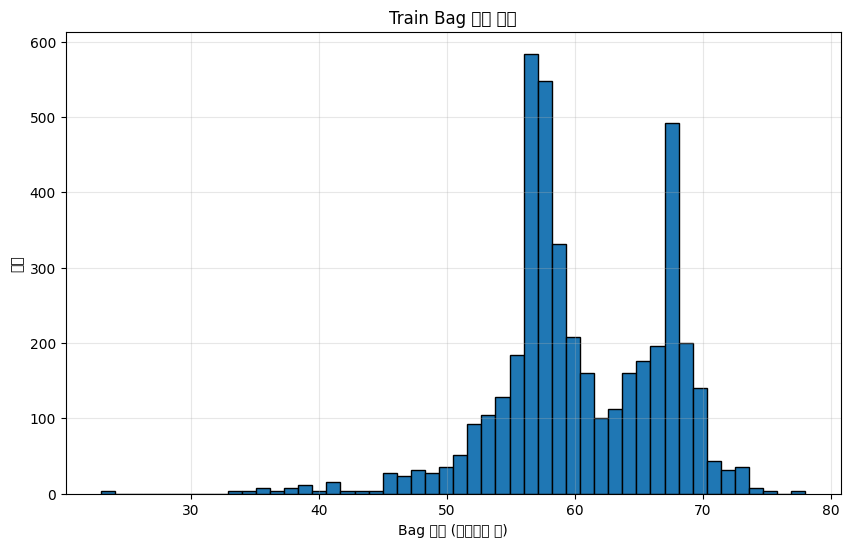

In [11]:
# Bag 데이터 분석
print("=== Bag 생성 결과 분석 ===")
print(f"Train bags 총 개수: {len(train_bags)}")
print(f"Val bags 총 개수: {len(val_bags)}")
print(f"Test bags 총 개수: {len(test_bags)}")

# Label 분포 확인
print("\n=== Label 분포 ===")
print(f"Train - False bags: {len(train_bags[train_bags['label']==False])}")
print(f"Train - True bags: {len(train_bags[train_bags['label']==True])}")
print(f"False/True 비율: {len(train_bags[train_bags['label']==False])/len(train_bags[train_bags['label']==True]):.2f}")

# Bag 크기 분석
print("\n=== Bag 크기 분석 ===")
bag_sizes = []
for idx, row in train_bags.iterrows():
    bag_sizes.append(len(row['features']))
    
import numpy as np
print(f"평균 Bag 크기: {np.mean(bag_sizes):.2f}")
print(f"최소 Bag 크기: {np.min(bag_sizes)}")
print(f"최대 Bag 크기: {np.max(bag_sizes)}")
print(f"표준편차: {np.std(bag_sizes):.2f}")

# True Bag의 교체 비율 분석
print("\n=== True Bag 교체 비율 분석 ===")
true_bags_only = train_bags[train_bags['label']==True]
replacement_ratios = []
for idx, row in true_bags_only.iterrows():
    if 'replacement_ratio' in row['metadata']:
        replacement_ratios.append(row['metadata']['replacement_ratio'])
    
if replacement_ratios:
    print(f"평균 교체 비율: {np.mean(replacement_ratios)*100:.2f}%")
    print(f"최소 교체 비율: {np.min(replacement_ratios)*100:.2f}%")
    print(f"최대 교체 비율: {np.max(replacement_ratios)*100:.2f}%")
else:
    print("교체 비율 정보를 찾을 수 없습니다.")

# 히스토그램 그리기
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(bag_sizes, bins=50, edgecolor='black')
plt.xlabel('Bag 크기 (인스턴스 수)')
plt.ylabel('빈도')
plt.title('Train Bag 크기 분포')
plt.grid(True, alpha=0.3)
plt.show()

## 문제점 발견

현재 MIL Bag 생성에서 발견된 중요한 문제점:

1. **교체 비율이 너무 낮음**: replacement_counts=[1]로 설정되어 있어 True bag에서 단 1개의 인스턴스만 교체됨
   - 평균 Bag 크기가 약 57-60개인데 1개만 교체하면 약 1.7% 교체율
   - 이는 너무 미미한 차이로 모델이 구분하기 어려움

2. **데이터 경로 문제**: autoencoder 데이터가 다른 경로에 저장되어 있음
   - 원본: `/data/csafeproject/CSAFE_version5/Document_Forgery/`
   - 프로젝트: `/workspace/MIL/data/processed/bags/`

3. **해결 방안**:
   - replacement_counts를 [5, 10, 15, 20] 등으로 증가시켜 더 명확한 차이 생성
   - 또는 Bag 크기를 줄여서 교체 비율을 높이기

In [12]:
# 데이터 누수 검증
print("=== 데이터 누수 검증 ===\n")

# 원본 데이터의 작성자 분리 확인
train_authors = set(train_data['label'].unique())
val_authors = set(val_data['label'].unique())
test_authors = set(test_data['label'].unique())

print("원본 데이터셋 작성자 분리:")
print(f"Train 작성자 수: {len(train_authors)}")
print(f"Val 작성자 수: {len(val_authors)}")
print(f"Test 작성자 수: {len(test_authors)}")
print(f"Train-Val 중복: {len(train_authors & val_authors)}")
print(f"Train-Test 중복: {len(train_authors & test_authors)}")
print(f"Val-Test 중복: {len(val_authors & test_authors)}")

# True Bag에서 교체된 작성자 확인
def check_bag_authors(bags_df, dataset_name):
    """True bag에서 사용된 모든 작성자 추출"""
    authors_in_bags = set()
    
    # False bag의 작성자
    for _, row in bags_df.iterrows():
        authors_in_bags.add(row['metadata']['label'])
        
        # True bag의 경우 교체된 작성자도 확인
        if row['label'] == True and 'index_mapping' in row['metadata']:
            for change in row['metadata']['index_mapping']:
                if 'new_label' in change:
                    authors_in_bags.add(change['new_label'])
    
    return authors_in_bags

train_bag_authors = check_bag_authors(train_bags, "Train")
val_bag_authors = check_bag_authors(val_bags, "Val")
test_bag_authors = check_bag_authors(test_bags, "Test")

print(f"\nBag 데이터에 포함된 작성자:")
print(f"Train bags 작성자 수: {len(train_bag_authors)}")
print(f"Val bags 작성자 수: {len(val_bag_authors)}")
print(f"Test bags 작성자 수: {len(test_bag_authors)}")

# 교집합 확인
print(f"\nBag 데이터 간 작성자 중복:")
print(f"Train-Val 중복: {len(train_bag_authors & val_bag_authors)}")
print(f"Train-Test 중복: {len(train_bag_authors & test_bag_authors)}")
print(f"Val-Test 중복: {len(val_bag_authors & test_bag_authors)}")

# 누수 여부 판단
if len(train_bag_authors & val_bag_authors) > 0 or len(train_bag_authors & test_bag_authors) > 0:
    print("\n⚠️ 경고: 데이터셋 간 작성자 중복이 발견되었습니다!")
    print("원본 데이터 분할 자체에 문제가 있을 수 있습니다.")
else:
    print("\n✅ 데이터 누수 없음: Bag 생성 시 각 데이터셋이 독립적으로 처리되었습니다.")

=== 데이터 누수 검증 ===

원본 데이터셋 작성자 분리:
Train 작성자 수: 60
Val 작성자 수: 20
Test 작성자 수: 20
Train-Val 중복: 0
Train-Test 중복: 0
Val-Test 중복: 0

Bag 데이터에 포함된 작성자:
Train bags 작성자 수: 60
Val bags 작성자 수: 20
Test bags 작성자 수: 20

Bag 데이터 간 작성자 중복:
Train-Val 중복: 0
Train-Test 중복: 0
Val-Test 중복: 0

✅ 데이터 누수 없음: Bag 생성 시 각 데이터셋이 독립적으로 처리되었습니다.
